# Import Corresponding Packages

In [1]:
import os

import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv

import matplotlib.pyplot as plt
import scipy.special as special
from matplotlib.patches import Patch
from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy import integrate
from IPython.display import Image, display, Latex
from sklearn import metrics
from sklearn import model_selection

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)

# Create Data

1. Here we are going to use Maxwellian-kernel to create data.
    * Complete diffuse scattering kernel for tangential velocity component
    $$
    R_{d, t} = \frac{1}{\sqrt{\pi}}\times\mathrm{exp}\left(-V_{t, r}^2\right) 
    $$
    * Specular kernel for tangential velocity component
    $$
    R_{s, t} = \delta (V_{i, t} - V_{r, t})
    $$
    * Maxwellian-type kernel
    $$
    R = \alpha_d \frac{1}{\sqrt{\pi}}\times\mathrm{exp}\left(-V_{t, r}^2\right) + (1-\alpha_d)\delta (V_{i, t} - V_{r, t})
    $$
2. In this problem, we could use $V_i = -1.0$ MPS. 

## Dirac Delta Function

1.0

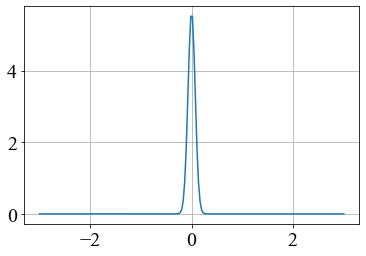

In [3]:
def diracFunc(x):
    return 5.641895835477563* np.exp(-x**2/0.01)

x = np.linspace(-3, 3, 200)
y = diracFunc(x)
plt.plot(x, y)  
plt.grid()
1 / integrate.simps(y, x)


In [4]:
[1, 2, 3]

[1, 2, 3]

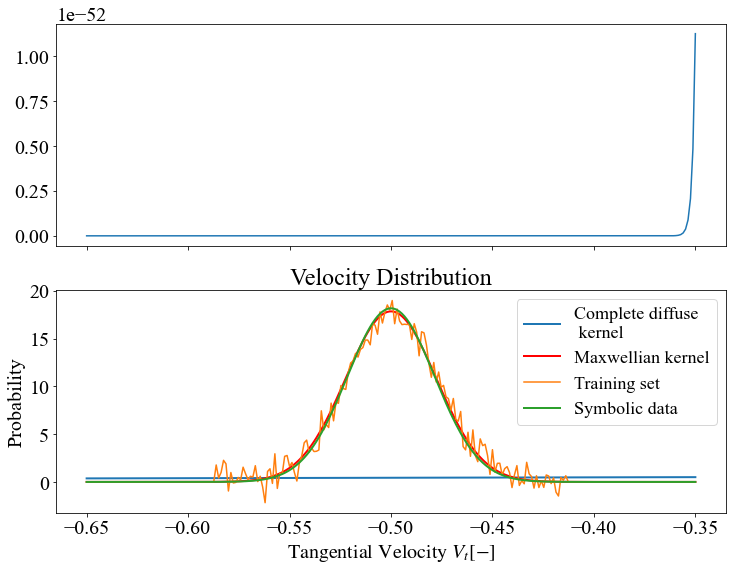

Scores: 0.4398


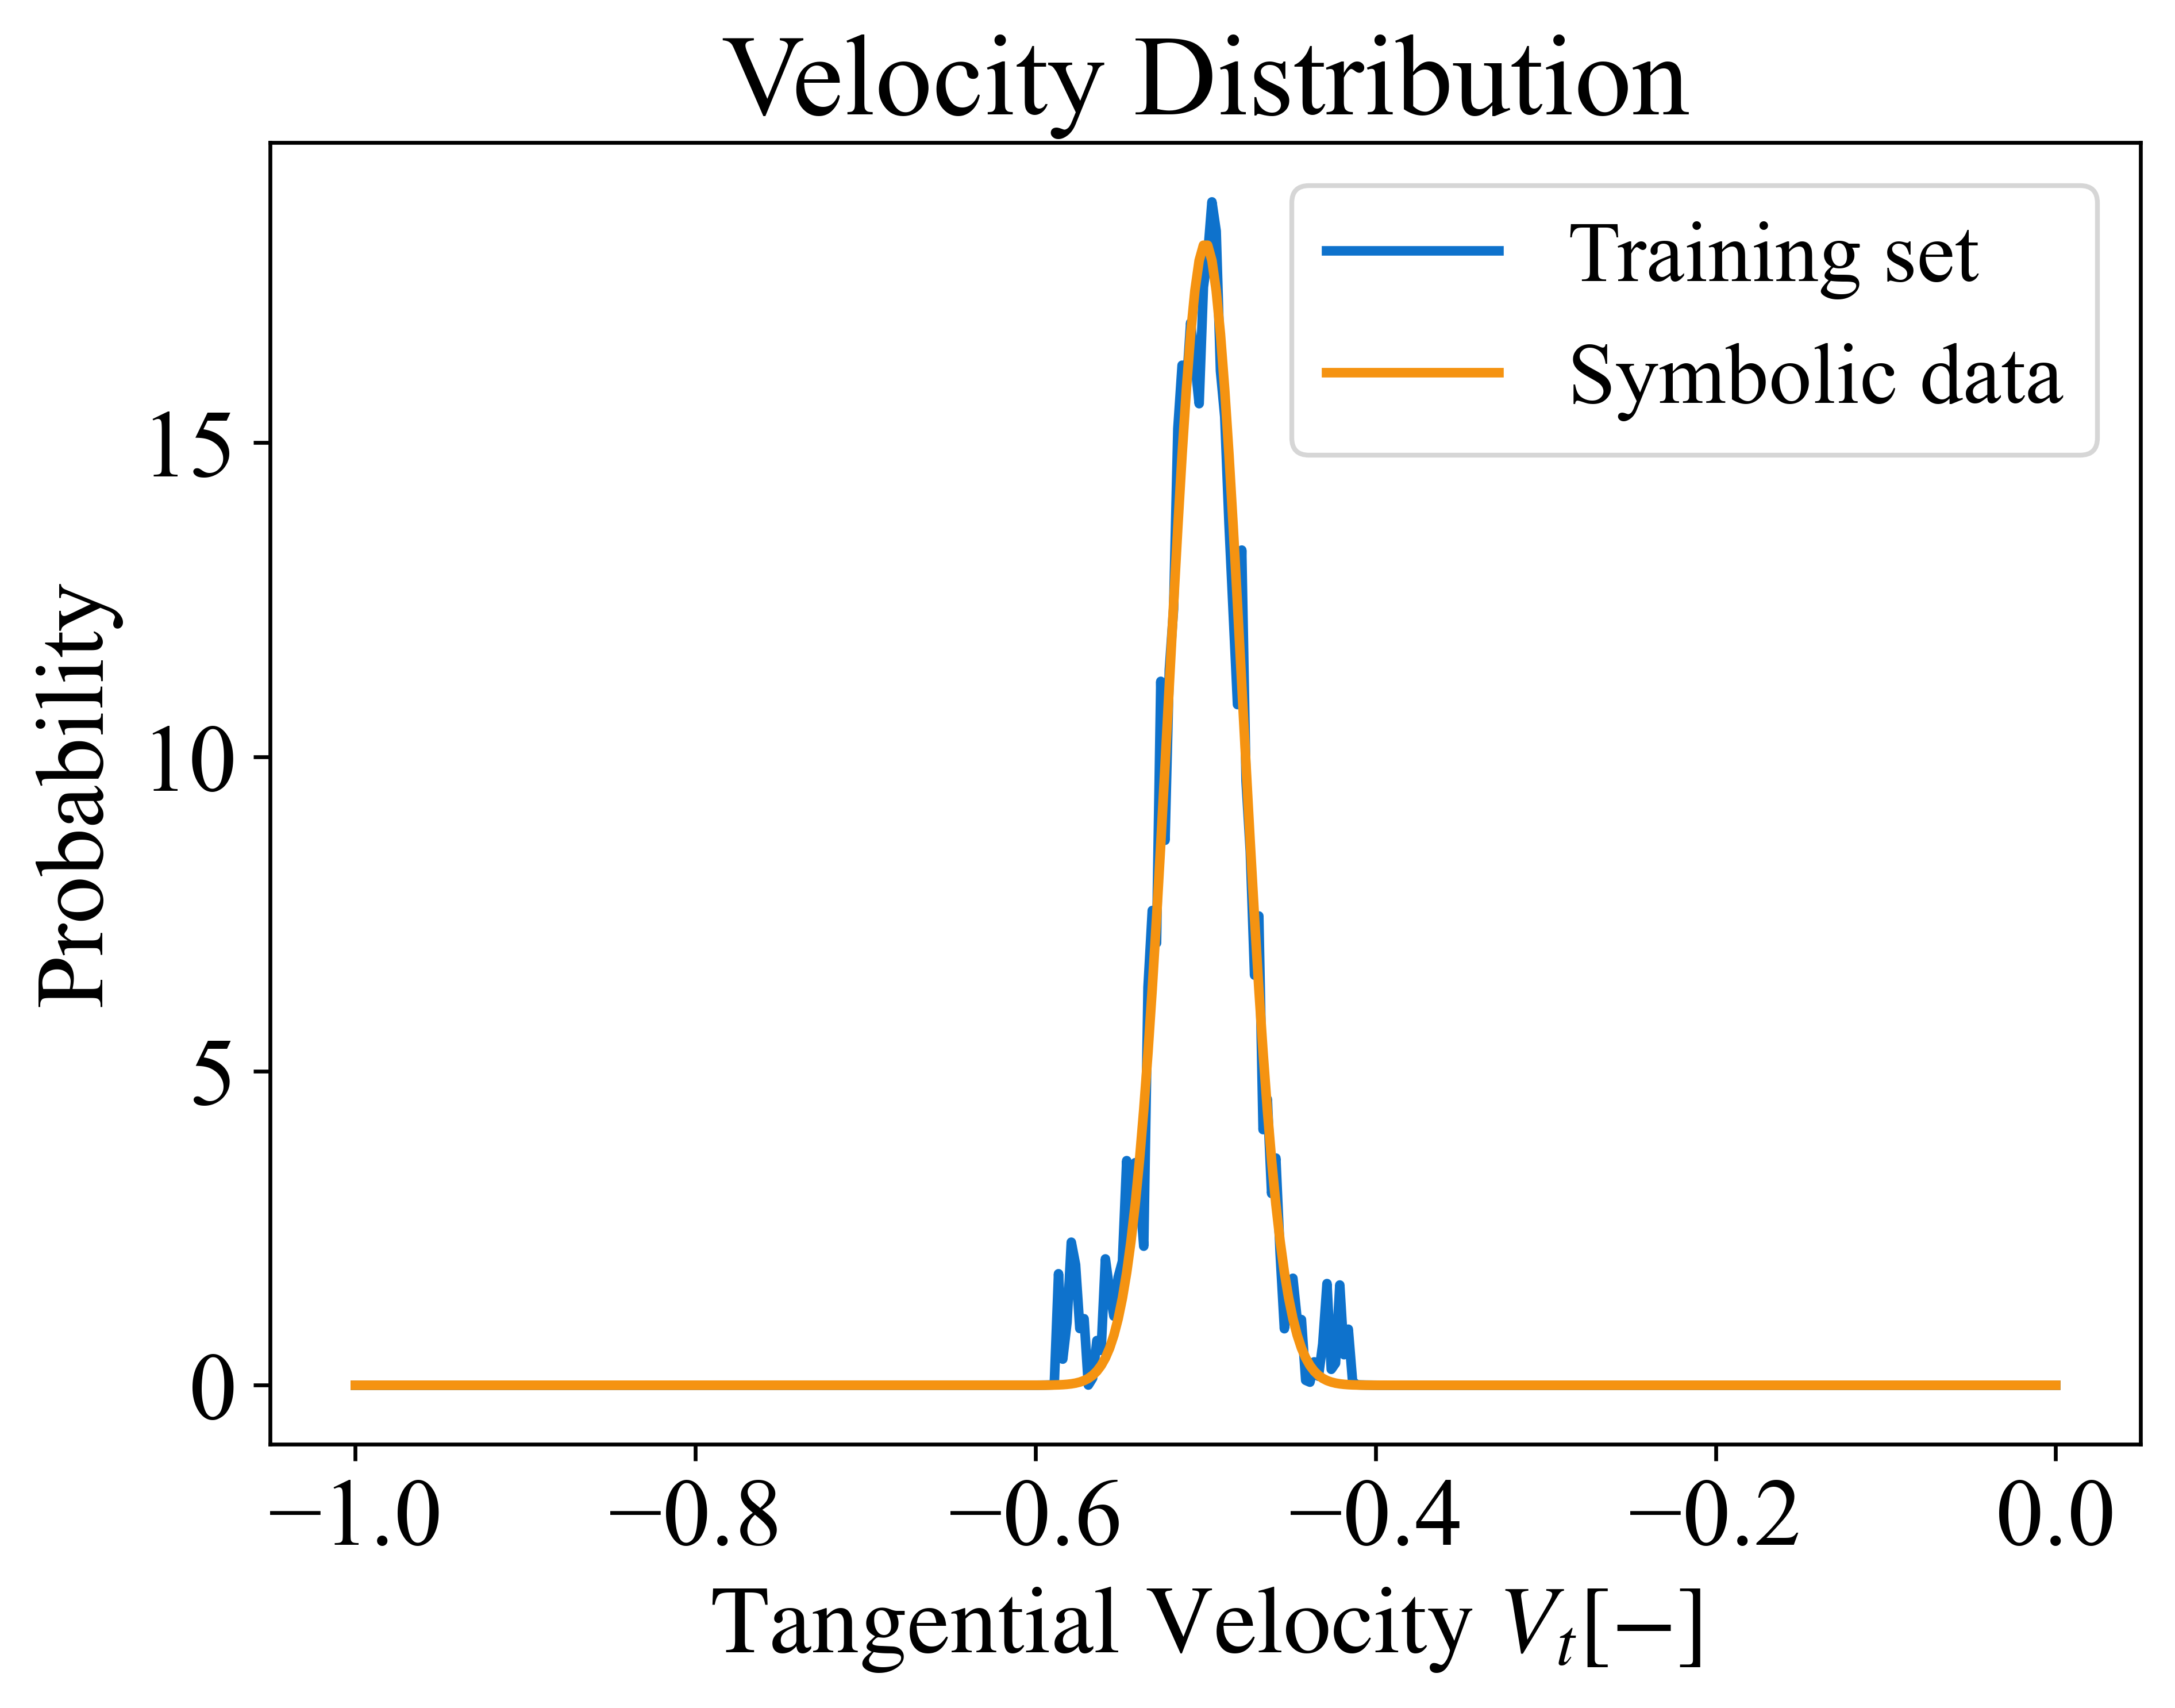

In [13]:
class CreateData():
    def __init__(self, alpha=0.9, vi=-0.5, traing_range=[-4, 4]):
        self.alpha = alpha
        self.VI = vi
        self.x_lower = traing_range[0]
        self.x_upper = traing_range[1]
    
    def diracFunc(self, x):
        """Dirac Delta Function."""
        return 17.85*np.exp(-x**2/0.001)

    def theoDataTan(self, x):
        """Tangential velocity part of complete diffuse kernel."""
        f1 = 1 / (np.sqrt(np.pi)) * np.exp(-np.power(x, 2))
        f2 = self.diracFunc(self.VI - x)

        return f1, f2# self.alpha*f1 + (1-self.alpha)*f2

    def trainingTan(self, x):
        random_state = np.random.RandomState(0)
        diffuse_y, y = self.theoDataTan(x)

        y_new = []
        for i, j in zip(x, y):
            if j >= 1e-2:
                noise = random_state.randn() 
                j = j + 1 * noise
            y_new.append(j)
            
        return diffuse_y, y, y_new
    
    def plotData(self):
        """
        @diffuse_y: Complete diffuse kernel
        @maxwellian_y: Complete diffuse kernle plus Specular kernel
        @noised_y: maxwellian_y plus noise.
        """
        x = np.linspace(self.x_lower, self.x_upper, 250)
        diffuse_y, maxwellian_y, noised_y = self.trainingTan(x)
        sym_func = lambda x: 18.170704189 * np.exp(-1076.65746*(-x + self.VI)**2)
        sym_y = sym_func(x)
        fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
        axes[0].plot(x, self.diracFunc(x))
        
        axes[1].plot(x, diffuse_y, label="Complete diffuse\n kernel", linewidth=2)
        axes[1].plot(x, maxwellian_y, label='Maxwellian kernel', linewidth=2, c='r')
        axes[1].plot(x, noised_y, label="Training set", linewidth=1.5)
        axes[1].plot(x, sym_y, label="Symbolic data", linewidth=2)
        axes[1].set_xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
        axes[1].set_ylabel("Probability")
        axes[1].set_title("Velocity Distribution")
        axes[1].legend(fontsize=18)
        plt.show()
        
        return x, maxwellian_y, np.array(noised_y)
    
    def plotComparison(self):
        """Plot the Training set, theoretical data, symbolic data."""
        x = np.linspace(-1, 0, 400)
        m, = x.shape
        sym_func = lambda x: 18.170704189 * np.exp(-1076.65746*(-x + self.VI)**2)
        sym_y = sym_func(x)
        diffuse_y, maxwellian_y, noised_y = self.trainingTan(x)
        scores = np.sqrt(np.sum((noised_y-sym_y)**2 )/ (m-2)) 
        print("Scores: {:.4f}".format(scores)) # 0.0929
        fig = plt.figure(figsize=(7, 5), dpi=600)
        
        plt.plot(x, np.abs(noised_y), label="Training set", linewidth=2, c='#0e72cc')
#         plt.plot(x, label="Theoretical data", linewidth=2, c="#6ca30f")
        plt.plot(x, sym_y, label="Symbolic data", linewidth=2, c="#f59311")
        plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
        plt.ylabel("Probability")
        plt.title("Velocity Distribution")
        plt.legend(fontsize=18)
        plt.savefig("./DEAP_Specular_tangential_sharp.svg", format='svg', dpi=1600, bbox_inches="tight")
        plt.show()
        
        
VI = -0.5
data_object = CreateData(alpha=0.7, vi=VI, traing_range=[-0.65, -0.35])
X, theo_y, noised_y = data_object.plotData()
data_object.plotComparison()

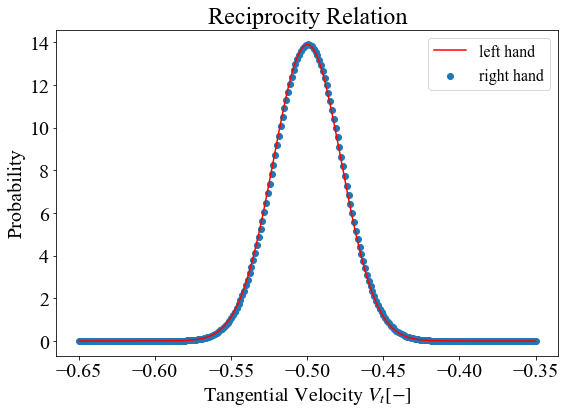

(0.778988350013145, 0.7791831213810527)

In [5]:
def theoDataTanNeg(x):
    def diracFunc(x):
        return 17.85*np.exp(-x**2/0.001)
    return diracFunc(VI-x)


righthand_theo_ = np.exp(-X**2)*theoDataTanNeg(X)
lefthand_theo = np.exp(-VI**2)*theo_y
plt.figure(figsize=(9, 6))
plt.plot(X, lefthand_theo, label="left hand", c='r')
plt.scatter(X, righthand_theo_, label="right hand")
plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
plt.ylabel("Probability")
plt.title("Reciprocity Relation")
plt.legend(fontsize=16)
plt.savefig("./DEPA_tangential_detailed_balance_sharp_theo.png")
plt.show()

integrate.simps(righthand_theo_, X), integrate.simps(lefthand_theo, X)

In [7]:
-VI*(lefthand_theo.max()-lefthand_theo.min())

6.948275019406891

# SR

In [6]:
# Tangential part
vi_list_tx = np.array([VI for i in range(len(X.squeeze()))])
X_TX = np.vstack((X.squeeze(), vi_list_tx)).T # 530 * 2 

In [7]:
"""Please note that, we change the definition of exponential function, which
could enhance the diversity of the model but also lead to no-solution problem."""

# Define new functions
def _protectedDiv(left, right):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
#         exp_f = np.exp(x**2)
        exp_f = np.exp(x**2)
        return np.where(exp_f > 9e6, 0, exp_f)


def Bessel(x):
    try:
        alpha = np.array([np.complex(0, x_part) for x_part in x])
    except Exception as e:
        alpha = np.complex(0, x)

    return special.jv(0, alpha).real


def createPset(key):
    pset = gp.PrimitiveSet("MAIN", 2)
    pset.addPrimitive(np.add, 2, name="add")
    pset.addPrimitive(np.subtract, 2, name="sub")
    pset.addPrimitive(np.multiply, 2, name="mul")
    pset.addPrimitive(_protectedDiv, 2, name="div")
#     pset.addPrimitive(np.square, 1, name='square')
    pset.addPrimitive(_protectedExp, 1, name="exp")
    pset.addPrimitive(np.negative, 1, name="neg")
#     pset.addTerminal(10)
    if key == "Normal":
        pset.addPrimitive(Bessel, 1, name="I0")

    # pset.addEphemeralConstant("rand_round", lambda: round(random.uniform(0, 3), ndigits=3))
    pset.addEphemeralConstant(
        "rand_round", lambda: np.round_(random.uniform(0, 10), decimals=3))

    pset.renameArguments(ARG0='x')
    pset.renameArguments(ARG1='y')

    return pset

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [9]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
    
    
    for mut_name in list(mutpb.keys()):
        if mut_name == 'full':
            for i in range(len(offspring)):
                if random.random() < mutpb['full']:
                    offspring[i], = toolbox.mutate_full(offspring[i])
                    del offspring[i].fitness.values
        else:
            for i in range(len(offspring)):
                if random.random() < mutpb['grow']:
                    offspring[i], = toolbox.mutate_grow(offspring[i])
                    del offspring[i].fitness.values

    return offspring


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(record['fitness']['min']))
            break 

    return population, logbook, record


In [10]:
class BaseSymReg():
    """creator has been treated as global one.
    --------------------------------
    Variables:
        _Data_info: Dictionary
            It should be the structure like the following example, 
            Data_info = {
                "X_train": X_TX,  # training  X, m*2, where m is number of sampling points.
                "y_train": PROB_TX,  # training y
                "fit": y_fit_normal,  # fit data, but for empirical data, it could be None
                "fit_para": fit_parameters_normal,  # same as before
                "theoretical": y_theo_normal,  # theoretical data, should be None for real
            }
            Here it contains the X, y we want to fit in our job. 
        _mutation_dic: Dictionary
            It should be the structure like *mutation_dic = {'full': 0.05, 'grow': 0.1}*.
            Since we only include two mutation tree generation ways, i.e., full
            and grow, the mutation probability should noly be the configuration
            like this.
        _pset: `gplean.gp.PrimitiveSet`
            It is a primitive set containing all the functions, variables and
            constant.
        save_path: string
            It is a path to save the comparison figure.
        _generation: int, default as 20
            The generation number.
        _penelty_coeff: list, default as [0, 0.001, 0.001]
            It is the coefficient before our L2 regularization, i.e., integration
            penalty.
        _height_max_value: int, default as 4
            It controls bloat problem in SR. The value here means the maximum
            length of the deepest tree.
        _pop_size: int, default as 2000
            The population size.
        _prob_cx_subtree: float, default as 0.5.
            Crossover action.
        _prob_cx_leaf: float, default as 0.1.
            Crossover action, but not the whole subtree.
        sk_kind: string
            There are two kinds of skcattering kernels, i.e. normal and
            tangential. In this class, we only accept `Normal` and `Tangential` 
            as our key word to do some analysis.
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 save_path,
                 generation=20,
                 population_size=2000,
                 height_max_value=4,
                 prob_cx_subtree=0.5,
                 prob_cx_leaf=0.1,
                 sk_kind="Normal",
                 penalty_coeff=[0, 0.001, 0.001]):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self.save_path = save_path
        self._generation = generation
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf
        self.sk_kind = sk_kind
        self._penelty_coeff = penalty_coeff

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self, ):
        toolbox = base.Toolbox()

        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=5)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            """At this function, we must consider so many exceptions for
            integration.
            ---------
                Points: m*2, m is the number of sampling points.
            """
            m, _ = points.shape
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            y_pred = func(points[:, 0], points[:, 1])
            numerator = np.sum((y_true - y_pred)**2)
            denominator = np.sum((y_true - np.average(y_true))**2)
            error = np.sqrt(numerator / denominator) / m
            # Probability should be larger than zero

            if np.array(y_pred < 0.0).any():
                P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
            else:
                P_1 = 0.0

            # Integration constraint
            try:
                """Sometimes the function could be a number."""
                inte = integrate.simps(y_pred, points[:, 0])
            except Exception as e:
                inte = y_pred * (np.max(points[:, 0]) - np.min(points[:, 0]))
            finally:
                with np.errstate(over='ignore'):
                    P_2 = np.abs(inte - 1)#**2
                    #P_2 = np.abs(inte-1)
            # Detailed balance
            if self.sk_kind == "Tangential":
                left = np.exp(-points[:, 1]**2) * func(points[:, 0], points[:,
                                                                            1])
                right = np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                P_3 = np.sqrt(np.average((left - right)**2))
                #P_3 = np.average(np.abs(left - right))
            elif self.sk_kind == "Normal":
                left = np.abs(points[:, 1]) * np.exp(-points[:, 1]**2) * func(
                    points[:, 0], points[:, 1])
                right = points[:, 0] * np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                with np.errstate(over='ignore'):
                    P_3 = np.sqrt(np.average((left - right)**2))
            else:
                raise ("Please Input Valid SKs Type during Creating Instance!")
            errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
                1] * P_2 + self._penelty_coeff[2] * P_3

            return errors,

        # Fitness function
        toolbox.register("evaluate",
                         evalSymbReg,
                         points=self._Data_info["X_train"],
                         y_true=self._Data_info["y_train"])
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=3)# int(self._pop_size / 100))
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=2)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=3)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, X, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """ 
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(X[:, 0], X[:, 1])

        if len(list(y_pred)) == 1:
            return 1.00
        else:
            return metrics.r2_score(y, y_pred)

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb=self._prob_cx_subtree,
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=False
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def _collectInfor(self, para_dic, total_time, hof, record):
        """Actually, we do not have to return the dictionary, since we set the 
        para_dic to global variable."""
        minute, second = self._timeTransfer(total_time)
        time_label = "Min: {:<3}, Sec: {:<3}".format(minute, second)
        para_dic["penalty"].append(self._penelty_coeff)
        para_dic["height_max_value"].append(self._height_max_value)
        para_dic["population"].append(self._pop_size)
        para_dic["prob_cx_subtree"].append(self._prob_cx_subtree)
        para_dic["prob_cx_leaf"].append(self._prob_cx_leaf)
        para_dic["mutation_full"].append(self._mutation_dic["full"])
        para_dic["mutation_grow"].append(self._mutation_dic["grow"])
        para_dic["generation"].append(self._generation)
        sym_expr, _ = self.treeTransfer(hof)
        para_dic["Sym Expr"].append(sym_expr)
        para_dic["Min Fitness"].append(record['fitness']['min'])
        para_dic["Total Time"].append(time_label)

        return para_dic

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
#         print("------get equation-----")
#         hof_tree_expr = sympy.simplify(
#             hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """
        X = self._Data_info["X_train"]
        x_1, x_2 = X[:, 0], X[:, 1]
        noised_y = self._Data_info["y_train"]
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = np.array(best_func(x_1, x_2))
        try:
            best_y.shape[0]
        except:
            best_y = [best_y for _ in range(x_1.shape[0])]
        
        if self.sk_kind == "Normal":
            theo_y = self._Data_info['theoretical']
        else:
            theo_y = self._Data_info["theoretical"]

        fig = plt.figure(figsize=(7, 5))

        plt.plot(x_1, noised_y, label='Training set', linewidth=2, c='#0e72cc')
        plt.plot(x_1, theo_y, label="Theoretical data", linewidth=2, c='#6ca30f')
        plt.plot(x_1, best_y, label="Symbolic Data", c='#f59311')
        if self.sk_kind == "Normal":
            plt.xlabel('$\mathrm{Normal\ Velocity}\ V_n[-]$')
        elif self.sk_kind == "Tangential":
            plt.xlabel('$\mathrm{Tangential\ Velocity}\ V_t[-]$')
        else:
            plt.xlabel("$\mathrm{Velocity}\ V[-]$")

        plt.ylabel('Probability')
        plt.title('Velocity Distribution')
        plt.legend(fontsize=16)

        plt.savefig(self.save_path)
        plt.show()

        theo_r2 = self.score(X, theo_y, best_tree)
        print("Theoretical R^2 = {:.3f}".format(theo_r2))
        training_r2 = self.score(X, noised_y, best_tree)
        print("Training R^2 = {:.3f}".format(training_r2))

    def treePlot(self, best_tree, path):
        nodes, edges, labels = gp.graph(best_tree)
        g = pgv.AGraph(ranksep="0.3", directed=True, strict=True)
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        g.layout(prog="dot")

        for i in nodes:
            node = g.get_node(i)
            # node.attr["label"] = labels[i]
            if isinstance(labels[i], float) or isinstance(labels[i], int):
                node.attr["label"] = np.round_(labels[i], decimals=3)
                node.attr['color'] = 'blue'
            else:
                node.attr["label"] = labels[i]
                if len(labels[i]) > 1:
                    node.attr['color'] = 'red'
                else:
                    node.attr['color'] = 'blue'

        g.draw(path)
        display(Image(path, height=150))

    def parameterTest(self):
        """This is a function with loop to test the hyper-parameter
        configurations.Sometimes you could save the test result in a Excel book.
        """

        # Gain the parameter list
        prob_cx_subtree_list = np.round_(np.arange(0.6, 0.9, 0.05), decimals=3)
        prob_cx_leaf_list = np.array(
            [np.round_(1 - x, decimals=3) for x in prob_cx_subtree_list])
        penalty_list = np.array([0.42, 0.44, 0.46, 0.48])

        para_dic = {
            'penalty': [],
            'height_max_value': [],
            'population': [],
            'prob_cx_subtree': [],
            'prob_cx_leaf': [],
            'mutation_full': [],
            "mutation_grow": [],
            'generation': [],
            "Sym Expr": [],
            "Min Fitness": [],
            "Total Time": [],
        }

        # Loop
        # Open excel file
        writer = pd.ExcelWriter('Log.xlsx')
        try:
            for penalty in penalty_list:
                # Time start
                time_start = time.time()

                # Rechange the data
                self._penelty_coeff = penalty

                # Main program
                print("---------------LOOP PENALTY {}-----------------".format(
                    penalty))
                pop, log, hof, record = self.main_program()
                print(log)

                # Print key information
                best_sr_expr, best_tree = baseSR_object.treeTransfer(hof)
                baseSR_object.plotComparison(best_tree)
                display(best_sr_expr)  # display the expression
                # Getting scores
                #r_2 = baseSR_object.score(TEST_DATA["X"], TEST_DATA["y"], best_tree)
                #print("R^2 = {:.3f}".format(r_2))

                # Time end
                time_end = time.time()
                total_time = time_end - time_start

                # Collect information
                self._collectInfor(para_dic, total_time, hof, record)

        except Exception as e:
            print("Eroor when looping")
            print(e)
        finally:
            df = pd.DataFrame(para_dic)
            df.to_excel(writer)
            writer.save()
            pass

In [11]:
# key = "Normal"
key = "Tangential"

pset = createPset(key)

In [12]:
"""Here, we changed the height_max_value to 5 instead of 4, so the bloat control 
is changed."""

class AdvancedSR(BaseSymReg):
    def __init__(self, Data_info, mutation_dic, pset, fig_path, tree_path,
            gene_size=3, pop_size = 2000, prob_cx_subtree=0.5, sk_kind="Tangential",
            penalty_list=[0, 0.04, 0.2]):
        super().__init__(Data_info, mutation_dic, pset, fig_path,
            generation=gene_size, population_size= pop_size, prob_cx_subtree=prob_cx_subtree, sk_kind=sk_kind,
            penalty_coeff=penalty_list, height_max_value=4)
        self.Data_info = Data_info
        self.tree_path = tree_path
        self._pset = pset
        
    def leftHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 1]**2) * function(V[:, 0], V[:, 1])
        else:
            return np.abs(V[:, 1])*np.exp(-V[:, 1]**2)*function(V[:, 0], V[:, 1])

    def rightHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 0]**2) * function(-V[:, 1], -V[:, 0])
        else:
            return V[:, 0] * np.exp(-V[:, 0]**2) * (function(-V[:, 1], -V[:, 0]))
    
    def mainRun(self):
        # Time counting starts
        time_start = time.time()
        
        # 1. Run evolutionary program
        print("{:-^80}".format("Tranining"))
        pop, log, hof, record = BaseSymReg.main_program(self)
        # 2. Obtain the best 
        print("{:-^80}".format("Symbolic Transformation"))
        best_sr_expr, best_tree = BaseSymReg.treeTransfer(self, hof)
        # 3. Plot the data
        print("{:-^80}".format("Plot Graph"))
        BaseSymReg.plotComparison(self, best_tree)
        # 4. Display the expression
        print("{:-^80}".format("Display Equation"))
        display(best_sr_expr)  
        # 5. Plot the tree structure
        print("{:-^80}".format("Plot Tree"))
        BaseSymReg.treePlot(self, best_tree, self.tree_path)
        
        # Time ending 
        time_end = time.time()
        total_time = time_end - time_start
        print("Total Time: {:.3f} s".format(total_time))

        return best_tree
    
    def reciprocityCon(self, best_tree_tx):
        if self.sk_kind == "Tangential":
            vi = self.Data_info["vincident"]
            func = gp.compile(str(best_tree_tx), pset=self._pset)
            a = np.linspace(-4, 4, num=100)
            b = np.array([vi for i in range(len(a))])
            train_x = np.vstack((a, b)).T
        else:
            vi = self.Data_info["vincident"]
            func = gp.compile(str(best_tree_normal), pset=pset)
            a_n = np.linspace(0.007, 4, num=100)
            b_n = np.array([vi for i in range(len(a_n))])
            train_x = np.vstack((a_n, b_n)).T

        lefthand = self.leftHand(func, train_x)
        righthand = self.rightHand(func, train_x)

        fig = plt.figure(figsize=(9, 6))
        plt.plot(train_x[:, 0], lefthand, label="left hand", c='red')
        plt.scatter(train_x[:, 0], righthand, label="right hand")
        plt.ylabel("Probability")
        plt.title("Reciprocity Relation")
        if self.sk_kind == "Tangential":
            plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
            plt.savefig("./DEPA_Specular_Tangential_detailed_balance")
        else:
            plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
            plt.savefig("./DEPA_Specular_Normal_detailed_balance")
        plt.legend(fontsize=18)
        plt.show()
    

In [15]:
def calculateFitness(best_tree_tx):
    m, _ = X_TX.shape
    # Transform the tree expression in a callable function
    func = gp.compile(str(best_tree_tx), pset)
    # Evaluate the mean squared error between the expression
    y_pred = func(X_TX[:, 0], X_TX[:, 1])
    numerator = np.sum((theo_y - y_pred)**2)
    denominator = np.sum((theo_y - np.average(theo_y))**2)
    error = np.sqrt(numerator / denominator) / m
    # Probability should be larger than zero

    if np.array(y_pred < 0.0).any():
        P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
    else:
        P_1 = 0.0

    # Integration constraint
    try:
        """Sometimes the function could be a number."""
        inte = integrate.simps(y_pred, X_TX[:, 0])
    except Exception as e:
        inte = y_pred * (np.max(X_TX[:, 0]) - np.min(X_TX[:, 0]))
    finally:
        with np.errstate(over='ignore'):
            P_2 = np.abs(inte - 1) #**2
            # P_2 = np.abs(inte-1)
    # Detailed balance
    if key == "Tangential":
        left = np.exp(-X_TX[:, 1]**2) * func(X_TX[:, 0], X_TX[:, 1])
        right = np.exp(-X_TX[:, 0]**2) * func(-X_TX[:, 1], -X_TX[:, 0])
        # P_3 = np.average((left - right)**2)
        P_3 = np.sqrt(np.average(np.abs(left-right)**2))
    elif key == "Normal":
        left = np.abs(X_NORMAL[:, 1]) * np.exp(-X_NORMAL[:, 1]**2) * func(
            X_NORMAL[:, 0], X_NORMAL[:, 1])
        right = X_NORMAL[:, 0] * np.exp(-X_NORMAL[:, 0]**2) * func(
            -X_NORMAL[:, 1], -X_NORMAL[:, 0])
        with np.errstate(over='ignore'):
            P_3 = np.sqrt(np.average(
                (left - right)**2)) 
    print(
        "Fitness information: ---------- \n Error: {:<20} \n P_1: {:<20} \n P_2: {:<20} \n P_3: {:<20}"
        .format(error, P_1, P_2, P_3))

-----------------------------------Tranining------------------------------------
The instance has been deleted
----------------------------Symbolic Transformation-----------------------------
-----------------------------------Plot Graph-----------------------------------
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 2.53450257e-06 3.46450694e-06 4.72098530e-06 6.41307582e-06
 8.68445588e-06 1.17236101e-05 1.57769348e-05 2.11653964e-05
 2.83056217e-05 3.77364899e-05 5.01525268e-05 6.64456644e-05
 8.77572471e-05 1.15542523e-04 1.51650280e-04 1.98420755e-04
 2.58805494e-04 3.36513429e-04 4.36188108e-04 5.63621763e-04
 7.26012672e-04 9.32273117e-04 1.19339615e-03 1.52289030

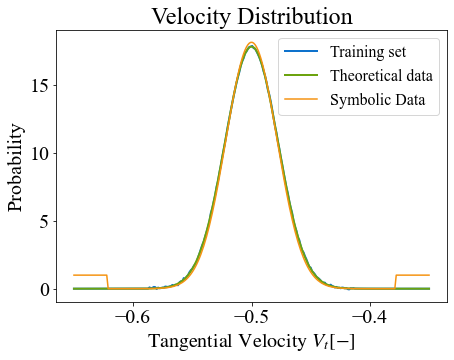

Theoretical R^2 = 0.993
Training R^2 = 0.993
--------------------------------Display Equation--------------------------------


18.170704189*exp(-1076.65746562668*(-x + y)**2)

-----------------------------------Plot Tree------------------------------------


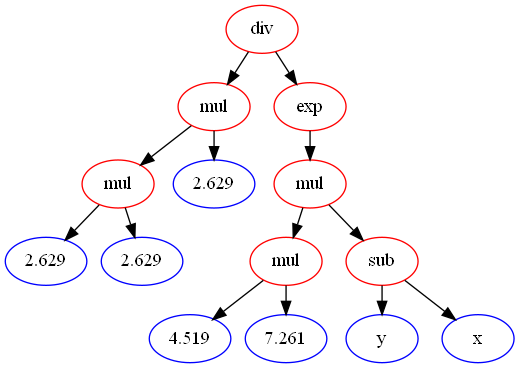

Total Time: 93.783 s


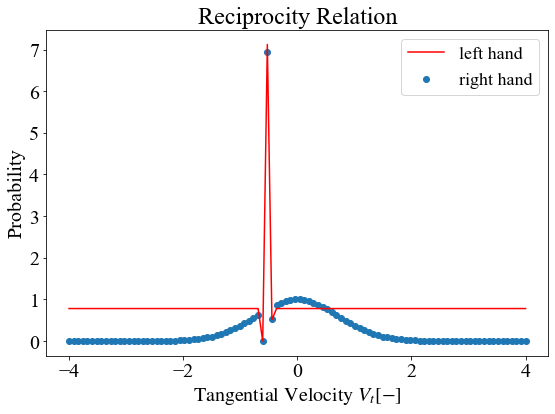

Fitness information: ---------- 
 Error: 0.0003380014977832896 
 P_1: 0.0                  
 P_2: 0.038166295194852484 
 P_3: 0.08944663127648354 


In [20]:
if __name__ == "__main__":
    mutation_dic_tx = {'full': 0.05, 'grow': 0.1}
    Data_info_tx = {
        "X_train": X_TX,
        "y_train": noised_y, #PROB_TX,
        "vincident": VI,
        "theoretical": theo_y,
    }
    fig_path_tx = './DEAP_Specular_tangential_sharp.png'
    tree_path_tx = "./DEAP_Specular_tangential_tree_sharp.png"
#     for num in [0.1, 0.05, 0.01, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]: #[1e-3, 1e-4, 1e-5, 1e-6]:
#         print("{:-^80}".format(num))
    advanceSR_object_tan = AdvancedSR(Data_info=Data_info_tx,
                           mutation_dic=mutation_dic_tx,
                           pset=pset,
                           fig_path=fig_path_tx,
                           tree_path=tree_path_tx,
                           gene_size=100,
                           pop_size=5000,
                           prob_cx_subtree=0.5,
                           sk_kind="Tangential",
                           penalty_list=[0.001, 1.1e-3, 0.001])
    best_tree_tx = advanceSR_object_tan.mainRun()
    advanceSR_object_tan.reciprocityCon(best_tree_tx)
    calculateFitness(best_tree_tx)
# 5e-6    

In [17]:
print("{:-^80}".format(12))

---------------------------------------12---------------------------------------


In [18]:
m, _ = X_TX.shape
# Transform the tree expression in a callable function
func = gp.compile(str(best_tree_tx), pset)
# Evaluate the mean squared error between the expression
y_pred = func(X_TX[:, 0], X_TX[:, 1])
numerator = np.sum((theo_y - y_pred)**2)
denominator = np.sum((theo_y - np.average(theo_y))**2)
error = np.sqrt(numerator / denominator) / m
# Probability should be larger than zero

if np.array(y_pred < 0.0).any():
    P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
else:
    P_1 = 0.0

# Integration constraint
try:
    """Sometimes the function could be a number."""
    inte = integrate.simps(y_pred, X_TX[:, 0])
except Exception as e:
    inte = y_pred * (np.max(X_TX[:, 0]) - np.min(X_TX[:, 0]))
finally:
    with np.errstate(over='ignore'):
        P_2 = (inte - 1) #**2
        # P_2 = np.abs(inte-1)
# Detailed balance
if key == "Tangential":
    left = np.exp(-X_TX[:, 1]**2) * func(X_TX[:, 0], X_TX[:, 1])
    right = np.exp(-X_TX[:, 0]**2) * func(-X_TX[:, 1], -X_TX[:, 0])
    # P_3 = np.average((left - right)**2)
    P_3 = np.sqrt(np.average(np.abs(left-right)**2))
elif key == "Normal":
    left = np.abs(X_NORMAL[:, 1]) * np.exp(-X_NORMAL[:, 1]**2) * func(
        X_NORMAL[:, 0], X_NORMAL[:, 1])
    right = X_NORMAL[:, 0] * np.exp(-X_NORMAL[:, 0]**2) * func(
        -X_NORMAL[:, 1], -X_NORMAL[:, 0])
    with np.errstate(over='ignore'):
        P_3 = np.sqrt(np.average(
            (left - right)**2))  
        
error, P_1, P_2, P_3

(0.0003380014977832896, 0.0, 0.038166295194852484, 0.08944663127648354)